# Bayesian Logistic Regression with PyMC3

In this notebook we will be using pymc3 to examine posterior probability distributions for the parameters in logistic regression for classification.

We start by importing our required libraries.

In [60]:
# This is a simple example of using pymc3 for Bayesian inference of the parameter distribution.
# written by William F Basener
# University of Virginia

import pymc3 as pm
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

We define a function that will be helpful for plotting.  This function does little mathematically, but will give us very nice trace plots.

In [61]:
def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

Load the data and look a the data frame.

In [62]:
data = pd.read_csv('../input/iris-flower-dataset/IRIS.csv')
data = data[['sepal_length','sepal_width','petal_length','petal_width','species']]
print(np.unique(data['species']))
data.describe()


['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [63]:
data.loc[data['species'] == 'Iris-setosa',:].mean()*10

sepal_length    50.06
sepal_width     34.18
petal_length    14.64
petal_width      2.44
dtype: float64

In [64]:
data.loc[data['species'] == 'Iris-setosa',:].cov()*10

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.242490,1.002980,0.161388,0.105469
sepal_width,1.002980,1.451796,0.116816,0.114367
petal_length,0.161388,0.116816,0.301061,0.056980
petal_width,0.105469,0.114367,0.056980,0.114939


We are using the seaborn plottng library.  This enables a very nice pairs plot for our classes.

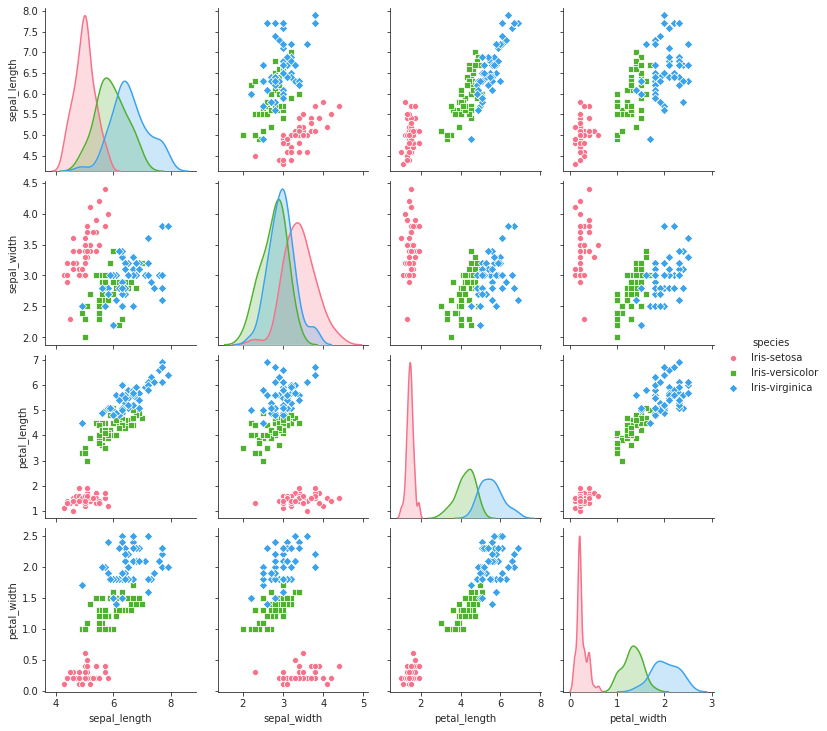

In [65]:
g = sns.pairplot(data, hue="species", palette="husl", markers=["o", "s", "D"])

# Question 1: Jamie's Plots: Strip Plot

## Explore the target variables versus species using the stripplot function from seaborn. 

## Stripplot is another represntation of observations and the underlying distribution. I included this as another way to visualize the separation (or lack thereof) between the three species' variables. As expected, there is significant overap between the species on the sepal length and sepal width plots. The data shows more separation with respect to the petal length and width. The overlapping sepal metrics preliminarily suggest that these variables may not be useful (or significant) in helping to distinguish between the classes.

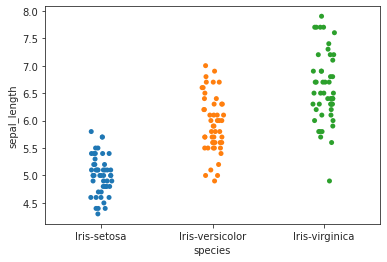

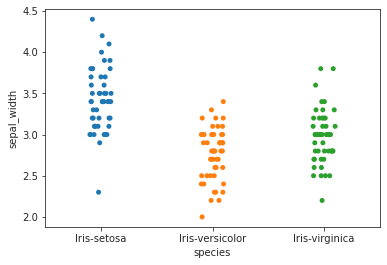

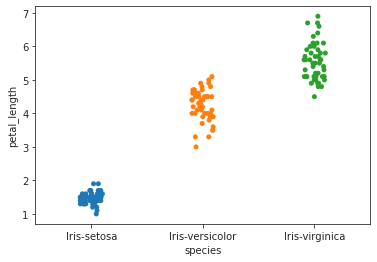

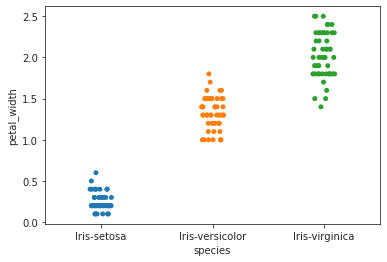

In [66]:
## Stripplot of Iris data

sns.stripplot(x="species", y="sepal_length", data=data, jitter=True)
plt.show();
sns.stripplot(x="species", y="sepal_width", data=data, jitter=True)
plt.show();
sns.stripplot(x="species", y="petal_length", data=data, jitter=True)
plt.show();
sns.stripplot(x="species", y="petal_width", data=data, jitter=True)
plt.show();

## See: https://towardsdatascience.com/building-a-bayesian-logistic-regression-with-python-and-pymc3-4dd463bbb16

# Question 1: Jamie's Plots: Violin Plot

## Violin plot provides a sense of the data's distribution for each variable. As will be discussed below, sepal length & wide have a central or middle distribtuion with little separation, which might be an indication that the data represents more than one class. Petal length & width each show two bumps indicating that there may be at least two different groupings or clusters in the data. This might help in distiguishing between the classes and suggests that we should pay attention to these variables as we continue to analyze the data.

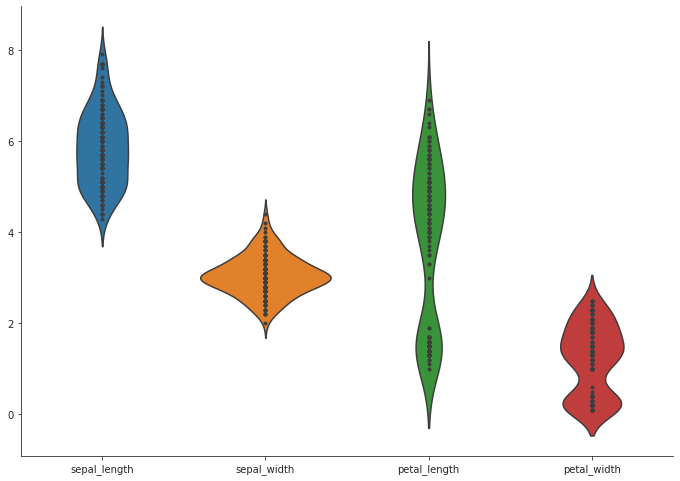

In [67]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.violinplot(data=data, inner="points", ax=ax)    
sns.despine()

fig.savefig('example.png')

# See: https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot
# See: https://mode.com/blog/violin-plot-examples/

# Question 1: Jamie's Plots: KDE Plot

## Ran KDE with shading & not - noticed overlap, but shading hid it KDE is a non-paramteeric way to estimate the PDF of a random variable - I was attempting to show different views of the relationships between the variables - with the intention of helping in our analysis of the importance of the the variables - espcially if they are zero. 

## Upon further reflection, my first approach - comparing the different pairs (code commented out in cell) did not lead to a clear conclusion. Perhaps naturally, each plot showed two 'humps' which reflects concentration of each type of the two types of data compared. After further thinking, I decided it might be more usfull to plot the data against it self.

## In fact, it was more useful in that it produced a visual result of the separation of the data in each varaible. For example, there are clearly two area of concentration in the petal length data as can be seen by the two completely separate 'magenta colored contours.  The blue (petal width) also shows separation but it is not as stark. To conclude, this was an interesting exercise, but I do not this this plot adds any more information that can be gleaned from the violin plot above.


In [68]:
# Drop 'species' categorical column becasue sns kdeplot (below) does not accept strings

data_nospecies = data.drop('species', 1)
data_nospecies

# See: https://seaborn.pydata.org/generated/seaborn.kdeplot.html

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'hue'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


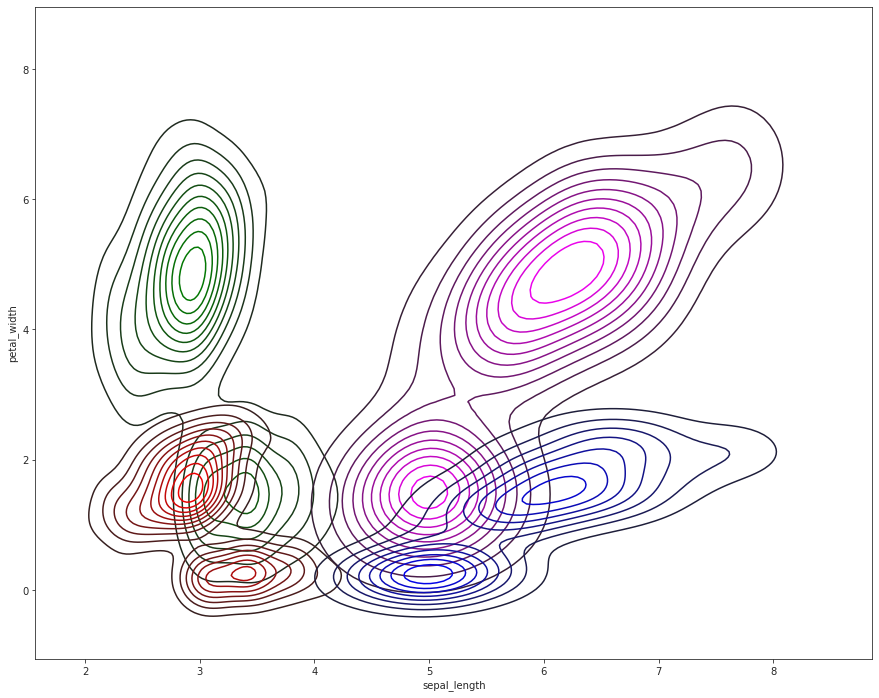

In [69]:
plt.figure(figsize=(15,12))

sns.kdeplot(data_nospecies.sepal_width, data_nospecies.petal_length, shade=False, hue=None, color='green')
sns.kdeplot(data_nospecies.sepal_width, data_nospecies.petal_width,shade=False, hue=None, color='red')
sns.kdeplot(data_nospecies.sepal_length, data_nospecies.petal_length,shade=False, hue=None, color='magenta')
sns.kdeplot(data_nospecies.sepal_length, data_nospecies.petal_width,shade=False, hue=None, color='blue')

# See: https://towardsdatascience.com/building-a-bayesian-logistic-regression-with-python-and-pymc3-4dd463bbb16
# See: https://seaborn.pydata.org/generated/seaborn.kdeplot.html
# Note that seaborn documentation shows some examples using iris dataset (which I noticed only at the end!)



## For code below, I am receving the error: 'numpy.linalg.LinAlgError: singular 
## matrix' when I runplots below, which work in kaggle. I found an article which 
## describes a fix, but I cannot seem to install the proper numpy sub-libraries.
## See: https://www.statology.org/python-numpy-linalg-singular-matrix/

#sns.kdeplot(x=data_nospecies.sepal_length, y=data_nospecies.sepal_length, shade=None, hue=None, color='yellow')
# sns.kdeplot(x=data_nospecies.sepal_width, y=data_nospecies.sepal_width, shade=False, hue=False, color='red')
# sns.kdeplot(x=data_nospecies.petal_length, y=data_nospecies.petal_length, shade=False, hue=False, color='magenta')
# sns.kdeplot(x=data_nospecies.petal_width, y=data_nospecies.petal_width, shade=False, hue=False, color='blue')

# Question 1: Jamie's Plots: Heat Map

## We plot a heat map to show the correlations between each variable - This plot perhaps makes the point I referenced above is that it suggests the relationship between the variables. For example, in weighing which variables to consider, the high correlation between petal length and petal width suggests a good place to start.

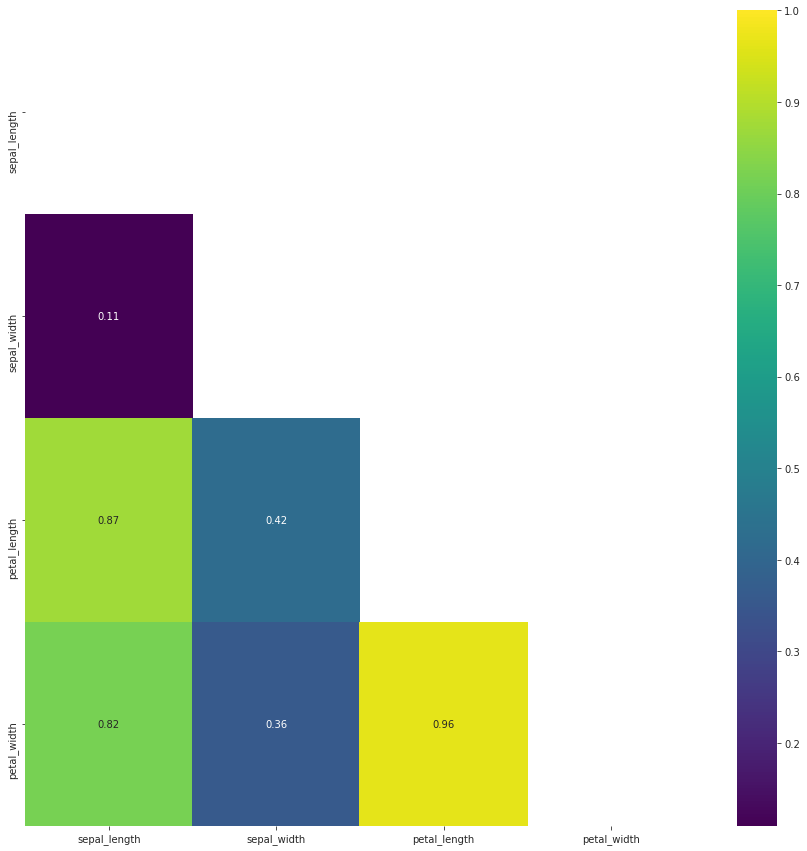

In [70]:
plt.figure(figsize=(15, 15))
corr = data.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis');

# See: https://towardsdatascience.com/building-a-bayesian-logistic-regression-with-python-and-pymc3-4dd463bbb16

# Question 1: PyMC3 traceplot, a matplotlib forestplot & seaborn joint plot. Plus my gratuitous graphviz graphic!

Now we perform our MCMC computaiton.  With pymc3, this is very easy.  We use the usual "with" declaration for pymc3, then use glm for our logistic model and just have to specidfy the formula, the data, and the family.  The family is what tells pymc3 that this will be logistic regression.

We are going to use the default priors for GLM coefficients from PyMC3, which is $p(\theta)=N(0,10^{12}I)$.  These are very weak priors.

In [71]:
with pm.Model() as model:
    pm.glm.GLM.from_formula(formula = 'species ~ sepal_length + sepal_width + petal_length + petal_width', 
                            data = data, 
                            family = pm.glm.families.Binomial())

    trace = pm.sample(1000)

Sampling 2 chains, 93 divergences: 100%|██████████| 3000/3000 [00:41<00:00, 71.96draws/s]


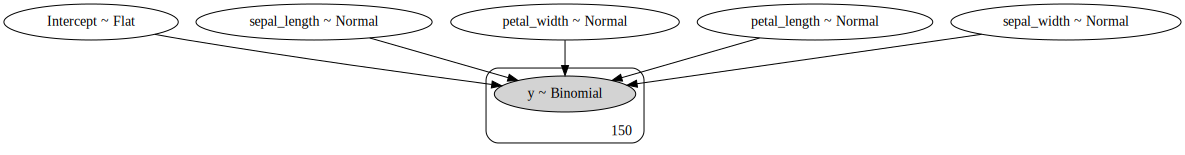

In [72]:
## I added this out of interest - I believe we discussed in class
## Defines the same logistic regression as a member of the Generalized Linear Models (GLM) family 

pm.model_to_graphviz(model)

# See: https://goldinlocks.github.io/Bayesian-logistic-regression-with-pymc3/

Here are the variable names in the output.  

In [73]:
trace.varnames

['Intercept', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [74]:
trace_simple = trace

In [75]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-75.879,37.055,-144.806,-20.800,2.518,1.792,217.0,214.0,240.0,499.0,1.01
sepal_length,-4.865,3.502,-11.471,1.387,0.173,0.123,409.0,409.0,431.0,784.0,1.01
sepal_width,-11.244,6.087,-23.192,-1.139,0.349,0.258,305.0,280.0,341.0,258.0,1.00
petal_length,17.783,7.821,5.118,31.847,0.538,0.381,212.0,212.0,209.0,354.0,1.01
petal_width,30.242,13.713,8.391,55.728,0.914,0.663,225.0,215.0,252.0,291.0,1.01


Here is our nice custom traceplot using the function plot_traces we defined previously.

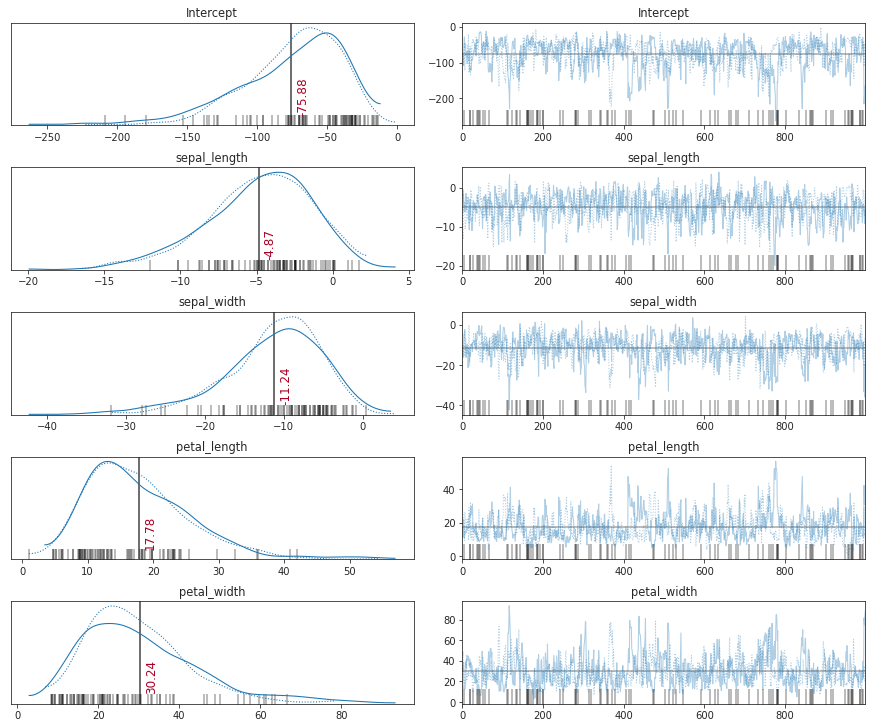

In [76]:
# PyMC3 trace is similar to an object that contains the output from MCMC sampling
plot_traces(trace)

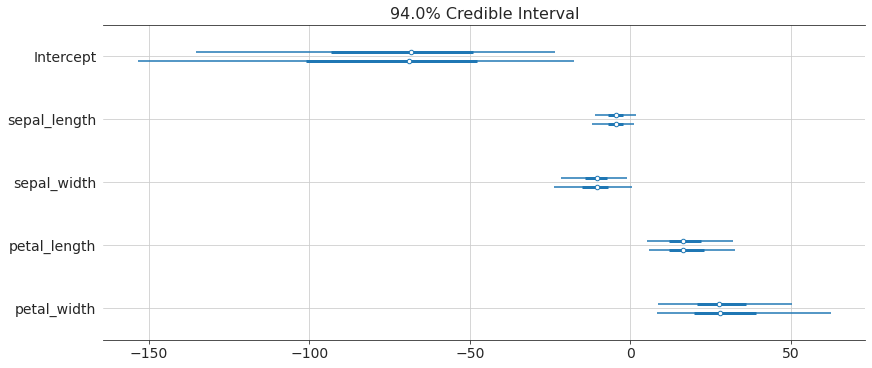

In [77]:
# The creates a matplotlib plot, so we can modify with standard matplotlib commands
pm.plots.forestplot(trace, figsize=(12, 5))
plt.grid()  # add a grid to the plot

<Figure size 648x504 with 0 Axes>

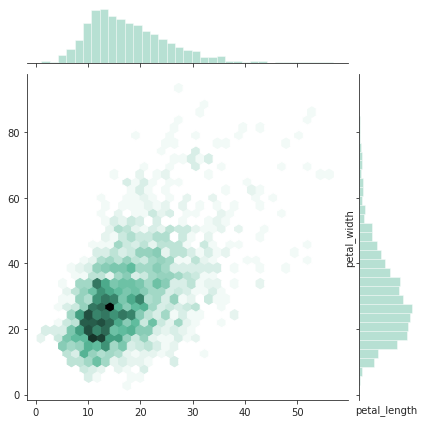

<Figure size 648x504 with 0 Axes>

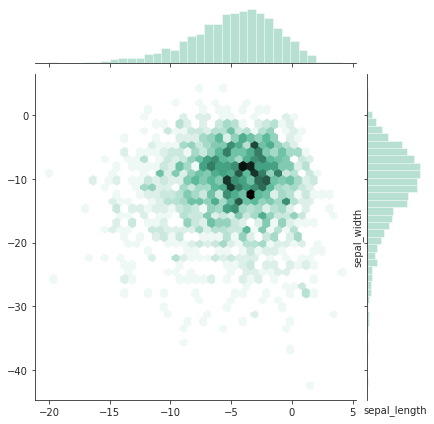

<Figure size 648x504 with 0 Axes>

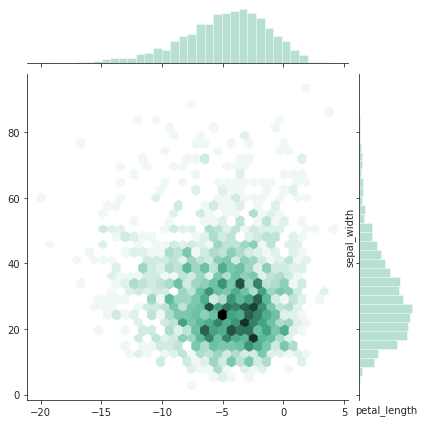

<Figure size 648x504 with 0 Axes>

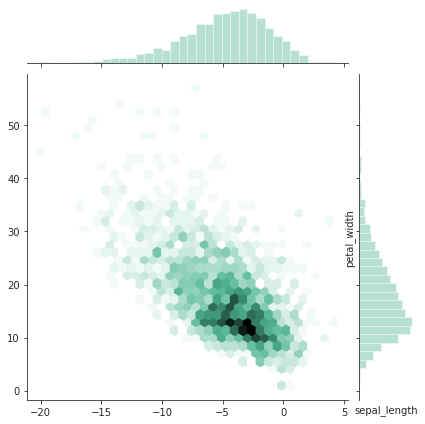

In [78]:
# Seaborn joint plot which plots datapairs for easy comparison

plt.figure(figsize=(9,7))
sns.jointplot(trace['petal_length'], trace['petal_width'], kind="hex", color="#4CB391")
plt.xlabel("petal_length")
plt.ylabel("petal_width");
plt.show()

plt.figure(figsize=(9,7))
sns.jointplot(trace['sepal_length'], trace['sepal_width'], kind="hex", color="#4CB391")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width");
plt.show()

plt.figure(figsize=(9,7))
sns.jointplot(trace['sepal_length'], trace['petal_width'], kind="hex", color="#4CB391")
plt.xlabel("petal_length")
plt.ylabel("sepal_width");
plt.show()

plt.figure(figsize=(9,7))
sns.jointplot(trace['sepal_length'], trace['petal_length'], kind="hex", color="#4CB391")
plt.xlabel("sepal_length")
plt.ylabel("petal_width");
plt.show()

# Question 1: Answer

## The results of our logistic regression model are expressed via three plots: a PyMC3 traceplot, a matplotlib forestplot, and a seaborn joint plot. In the trace plot, the predictor variables that are most likely to be zero are those with whose marginalized distribution plot (the plots on the left-hand side in the traceplot) includes zero. In this case, the sepal length and sepal width plots both include zero. Accordingly, they both have somelikelihood that coefficient could be zero. It's possible that sepal length could be slightly more likely to be zero because zero is slightly closer (visually) towards the center of the distribution that in the sepal width plot.

## A similar conclusion can be drwn from examining the credible intervals in the forest plot. Both chains in the sepal length credible interval 'touch' the zero line. In the sepal width plot, one of the two chains touches the zero line, and the othert is very close to zero and much closer than any of the other variables' chains.

## The jointplot plots two variables together. The darker hexagons in the plot indicate some relationship between the two dimensions. The darkest areas reflect the highest probabilities. Similar to the plots above, the plots that show darker hexes around or at zero have an increased probability of being zero. This can expressly be seen in the second plot (sepal length x sepal width) where colored/darker hexes are on around around zero on both axes.

### See: https://docs.exoplanet.codes/en/latest/tutorials/intro-to-pymc3/¶

### Question 1 - Appendix -  I worked a little bit ahead with below.

In [79]:
## Run Automatic Differentation Variational Inference (ADVI)
## ADVI is an alternative method to CAVI to maximize the ELBO

from pymc3.variational.callbacks import CheckParametersConvergence
with model:
    callback = CheckParametersConvergence(diff='absolute')
    approx = pm.fit(n=1000, callbacks=[callback])
    
# See: https://luiarthur.github.io/statorial/varinf/introvi/
# See: https://goldinlocks.github.io/Bayesian-logistic-regression-with-pymc3/

Average Loss = inf: 100%|██████████| 1000/1000 [00:00<00:00, 1844.92it/s]  


In [80]:
# Persist result
from pathlib import Path
import pickle
from collections import OrderedDict
with open('model_advi.pkl', 'wb') as buff:
    pickle.dump({'model': model,
                 'approx': approx}, buff)

In [81]:
# Draw samples from the approximated distribution to obtain a trace object as above for the MCMC sampler:
trace_advi = approx.sample(200)

In [82]:
pm.summary(trace_advi)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.086,0.684,-1.329,1.014,0.056,0.039,150.0,150.0,145.0,182.0,NaN
sepal_length,-0.022,0.627,-1.229,1.067,0.048,0.034,173.0,172.0,170.0,153.0,NaN
sepal_width,-0.090,0.567,-1.093,0.950,0.041,0.030,190.0,176.0,189.0,153.0,NaN
petal_length,0.011,0.639,-1.068,1.231,0.044,0.031,212.0,212.0,213.0,190.0,NaN
petal_width,0.074,0.697,-1.160,1.284,0.047,0.033,223.0,223.0,220.0,185.0,NaN


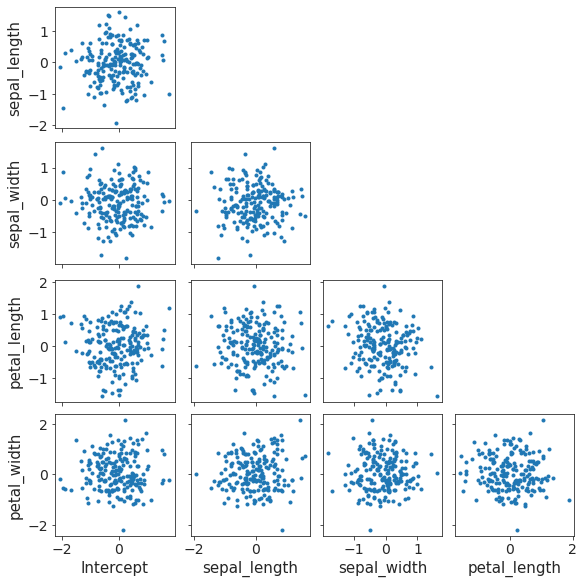

In [83]:
# Visualize the covariance structure of the model
# Professor Basener - I have some questions about this

import arviz as az

az.plot_pair(trace_advi, figsize=(8, 8));

# Question 3. Logistic Regression for Predicting Coronary Heart Disease
# Base Case - Logistic Regression

Now lets apply some Bayesian Regression techniques to a healthcare problem of determining risk for Coronary Heart Disease.  Logistic Regression is a great method for this problem because it provides esitmates of probability of heart disease and the Bayesian analysis provides insight into uncertainty and importance of the different predicotr variables.

In [84]:
chd_data = pd.read_csv("../input/coronary-heart-disease/CHDdata.csv")
chd_data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [85]:
chd_data.describe()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000


In [86]:
# Standardize the data (mean for each numerical variable of zero, standard deviation of one.)
for key in chd_data.keys()[0:9]:
    try:
        print("Standardizing "+key+".")
        chd_data[key] = chd_data[key] - np.mean(chd_data[key])
        chd_data[key] = chd_data[key] / np.std(chd_data[key])
    except:
        print("Predictor "+key+" cannot be standardized (probably a categorical variable).")
chd_data.describe()

Standardizing sbp.
Standardizing tobacco.
Standardizing ldl.
Standardizing adiposity.
Standardizing famhist.
Predictor famhist cannot be standardized (probably a categorical variable).
Standardizing typea.
Standardizing obesity.
Standardizing alcohol.
Standardizing age.


,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,462.000000
mean,-2.571296e-16,5.022437e-16,-3.963040e-15,1.559599e-15,1.153478e-17,-5.286776e-15,-4.169344e-16,1.970526e-17,0.346320
std,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,0.476313
min,-1.823123e+00,-7.924170e-01,-1.817753e+00,-2.401708e+00,-4.089354e+00,-2.695129e+00,-6.969825e-01,-1.906103e+00,0.000000
25%,-6.997535e-01,-7.809742e-01,-7.047170e-01,-7.245926e-01,-6.224081e-01,-7.267824e-01,-6.761275e-01,-8.096968e-01,0.000000
50%,-2.113321e-01,-3.565020e-01,-1.935182e-01,9.112757e-02,-1.059418e-02,-5.680824e-02,-3.898822e-01,1.496582e-01,0.000000
75%,4.724579e-01,4.063492e-01,5.074164e-01,7.489145e-01,7.031887e-01,5.828745e-01,2.800340e-01,8.349118e-01,1.000000
max,3.891408e+00,6.007857e+00,5.119082e+00,2.197976e+00,2.538631e+00,4.878906e+00,5.321938e+00,1.451640e+00,1.000000


In [87]:
# Lets check the mean of each class to get a first look at the separation
print("Mean for CHD Positive:")
print(np.array([chd_data[chd_data.chd == 1].mean()[0:8]]))
print("Mean for CHD Negative:")
print(np.array([chd_data[chd_data.chd == 0].mean()[0:8]]))

Mean for CHD Positive:
[[0.26426823 0.41177089 0.36139839 0.34912802 0.14172199 0.13751694
  0.0859086  0.51241433]]
Mean for CHD Negative:
[[-0.14000966 -0.21815676 -0.19146935 -0.18496849 -0.0750845  -0.07285666
  -0.04551449 -0.27147779]]


In [88]:
chd_data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.058564,1.823073,0.478412,-0.295503,Present,-0.418470,-0.176786,3.277738,0.629336,1
1,0.277089,-0.790237,-0.159680,0.412140,Absent,0.193344,0.671373,-0.612745,1.383115,1
2,-0.992806,-0.774980,-0.609245,0.884332,Present,-0.112563,0.735519,-0.541183,0.218184,0
3,1.546985,0.842264,0.807126,1.624141,Present,-0.214532,1.412621,0.295062,1.040488,1
4,-0.211332,2.171805,-0.599577,0.305351,Present,0.703189,-0.012856,1.647775,0.423760,1


# Question 3: Answer
# Create Logistic Regression model with CHD dataset - with priors

Average Loss = 356.82: 100%|██████████| 50000/50000 [00:34<00:00, 1456.58it/s]


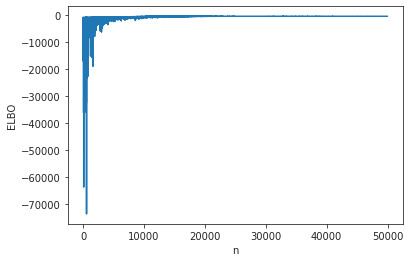

In [89]:
with pm.Model() as model:
    # Define priors for intercept & regression coefficients
    # x5 is categorical predictor 'famhist' - using uninformative prior
    # Note however the source footnoted below - "there is no such thing as
    # an uninformative (beta (prior)"
    
    priors = {
        "Intercept": pm.Normal.dist(mu=0.0, sigma=1.0),
        "sbp": pm.Normal.dist(mu=0.0, sigma=1.0),
        "tobacco": pm.Normal.dist(mu=0.0, sigma=1.0),
        "ldl": pm.Normal.dist(mu=0.0, sigma=1.0),
        "adiposity": pm.Normal.dist(mu=0.0, sigma=1.0),
        "famhist": pm.Beta.dist(alpha=1.0, beta=1.0),
        "typea": pm.Normal.dist(mu=0.0, sigma=1.0),
        "obesity": pm.Normal.dist(mu=0.0, sigma=1.0),
        "alcohol": pm.Normal.dist(mu=0.0, sigma=1.0),
        "age": pm.Normal.dist(mu=0.0, sigma=1.0),
    }
    pm.glm.GLM.from_formula(formula = 'chd ~ sbp + tobacco + ldl + adiposity + famhist + typea + obesity + alcohol + age', 
                            data = chd_data, 
                            family = pm.glm.families.Normal())

    trace = pm.sample(5000) 
    approx = pm.fit(50000, method = 'advi')
    
# See: https://stats.stackexchange.com/questions/297901/choosing-between-uninformative-beta-priors
# See: https://docs.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-out-of-sample-predictions.html?highlight=family
# See: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-model-selection.html?highlight=family

advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [90]:
trace_VI = approx.sample(draws=5000)

In [91]:
# Plot both traces - commented out for homework brevity
#plot_traces(trace)
#plot_traces(trace_VI)

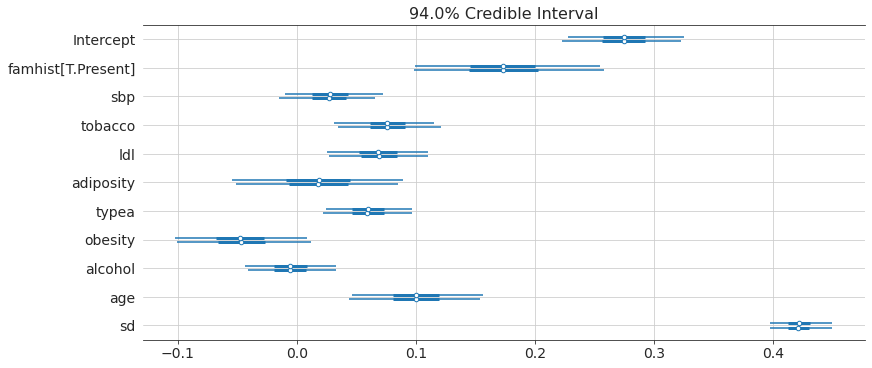

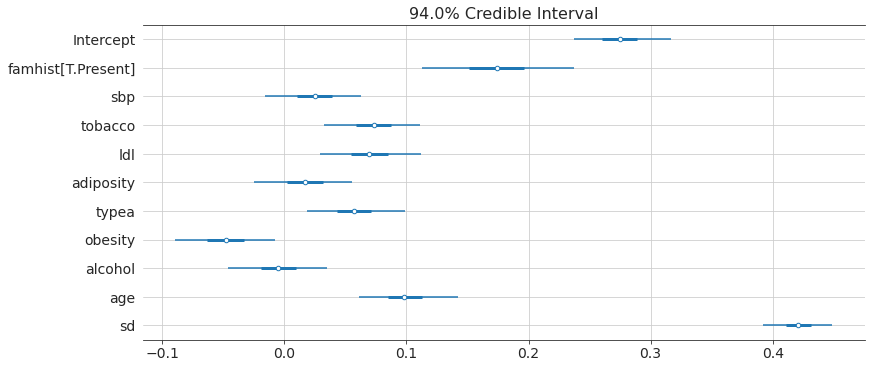

In [92]:
# The creates a matplotlib plot, so we can modify with standard matplotlib commands
pm.plots.forestplot(trace, figsize=(12, 5))
plt.grid()  # add a grid to the plot
pm.plots.forestplot(trace_VI, figsize=(12, 5))
plt.grid()  # add a grid to the plot

# Note the difference between the data from the trace_VI and trace summaries blow

In [93]:
pm.summary(trace_VI).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.28,0.02,0.24,0.32,0.0,0.0,4857.0,4834.0,4859.0,5025.0,NaN
famhist[T.Present],0.17,0.03,0.11,0.24,0.0,0.0,4837.0,4803.0,4836.0,4791.0,NaN
sbp,0.02,0.02,-0.02,0.06,0.0,0.0,5029.0,5029.0,5030.0,4581.0,NaN
tobacco,0.07,0.02,0.03,0.11,0.0,0.0,4978.0,4959.0,4979.0,4740.0,NaN
ldl,0.07,0.02,0.03,0.11,0.0,0.0,4930.0,4930.0,4926.0,4917.0,NaN
adiposity,0.02,0.02,-0.02,0.06,0.0,0.0,4801.0,4801.0,4800.0,4752.0,NaN
typea,0.06,0.02,0.02,0.10,0.0,0.0,4509.0,4509.0,4510.0,5012.0,NaN
obesity,-0.05,0.02,-0.09,-0.01,0.0,0.0,4878.0,4878.0,4873.0,4392.0,NaN
alcohol,-0.00,0.02,-0.05,0.04,0.0,0.0,4876.0,4811.0,4891.0,4852.0,NaN
age,0.10,0.02,0.06,0.14,0.0,0.0,4617.0,4541.0,4634.0,4338.0,NaN


In [94]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.274,0.026,0.223,0.322,0.0,0.0,9578.0,9554.0,9576.0,8109.0,1.0
famhist[T.Present],0.173,0.042,0.097,0.255,0.0,0.0,9464.0,9376.0,9485.0,8152.0,1.0
sbp,0.028,0.022,-0.015,0.067,0.0,0.0,16036.0,10475.0,16020.0,7749.0,1.0
tobacco,0.076,0.022,0.033,0.119,0.0,0.0,14122.0,13015.0,14093.0,8416.0,1.0
ldl,0.069,0.023,0.026,0.110,0.0,0.0,15594.0,13926.0,15588.0,7361.0,1.0
adiposity,0.018,0.038,-0.053,0.087,0.0,0.0,7180.0,6162.0,7189.0,7869.0,1.0
typea,0.060,0.020,0.023,0.097,0.0,0.0,13684.0,11963.0,13703.0,7117.0,1.0
obesity,-0.047,0.030,-0.102,0.010,0.0,0.0,8273.0,7707.0,8281.0,7598.0,1.0
alcohol,-0.006,0.020,-0.041,0.034,0.0,0.0,14123.0,5371.0,14131.0,7710.0,1.0
age,0.100,0.029,0.046,0.157,0.0,0.0,8154.0,8154.0,8166.0,7658.0,1.0


# Answer 3, 2nd Part:
# Plot densities & posteriors from sampling with prior

In [95]:
## Transpose column names to be able to run a list comprehension
## to create my posterior density plot below

col_list = pm.summary(trace).T
#col_list

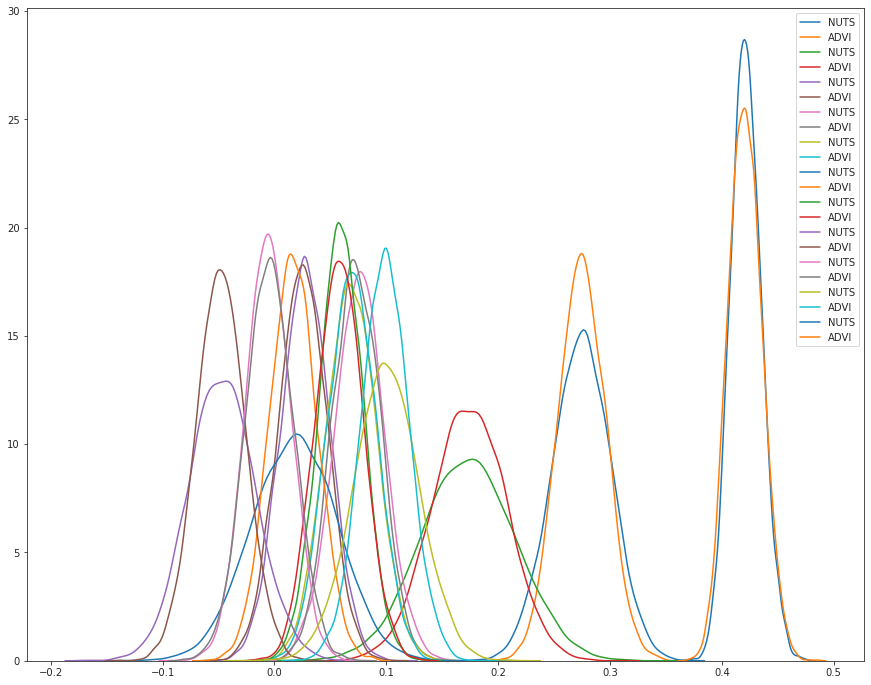

In [96]:
## Posteriors density plot - It's a little messy, but it's kind of cool!
## Use list comprehension to iterate through variables
## And, you can see the difference between NUTS and ADVI...

## For this to work, the following code must be uncommented for MCMC
## sampling: trace = pm.sample(5000)

import seaborn as sns
plt.figure(figsize=(15,12))

for col in col_list:
  ax = sns.kdeplot(trace[col], label="NUTS")
  sns.kdeplot(approx.sample(10000)[col], label="ADVI");
    
# See: https://docs.pymc.io/en/v3/pymc-examples/examples/variational_inference/variational_api_quickstart.html

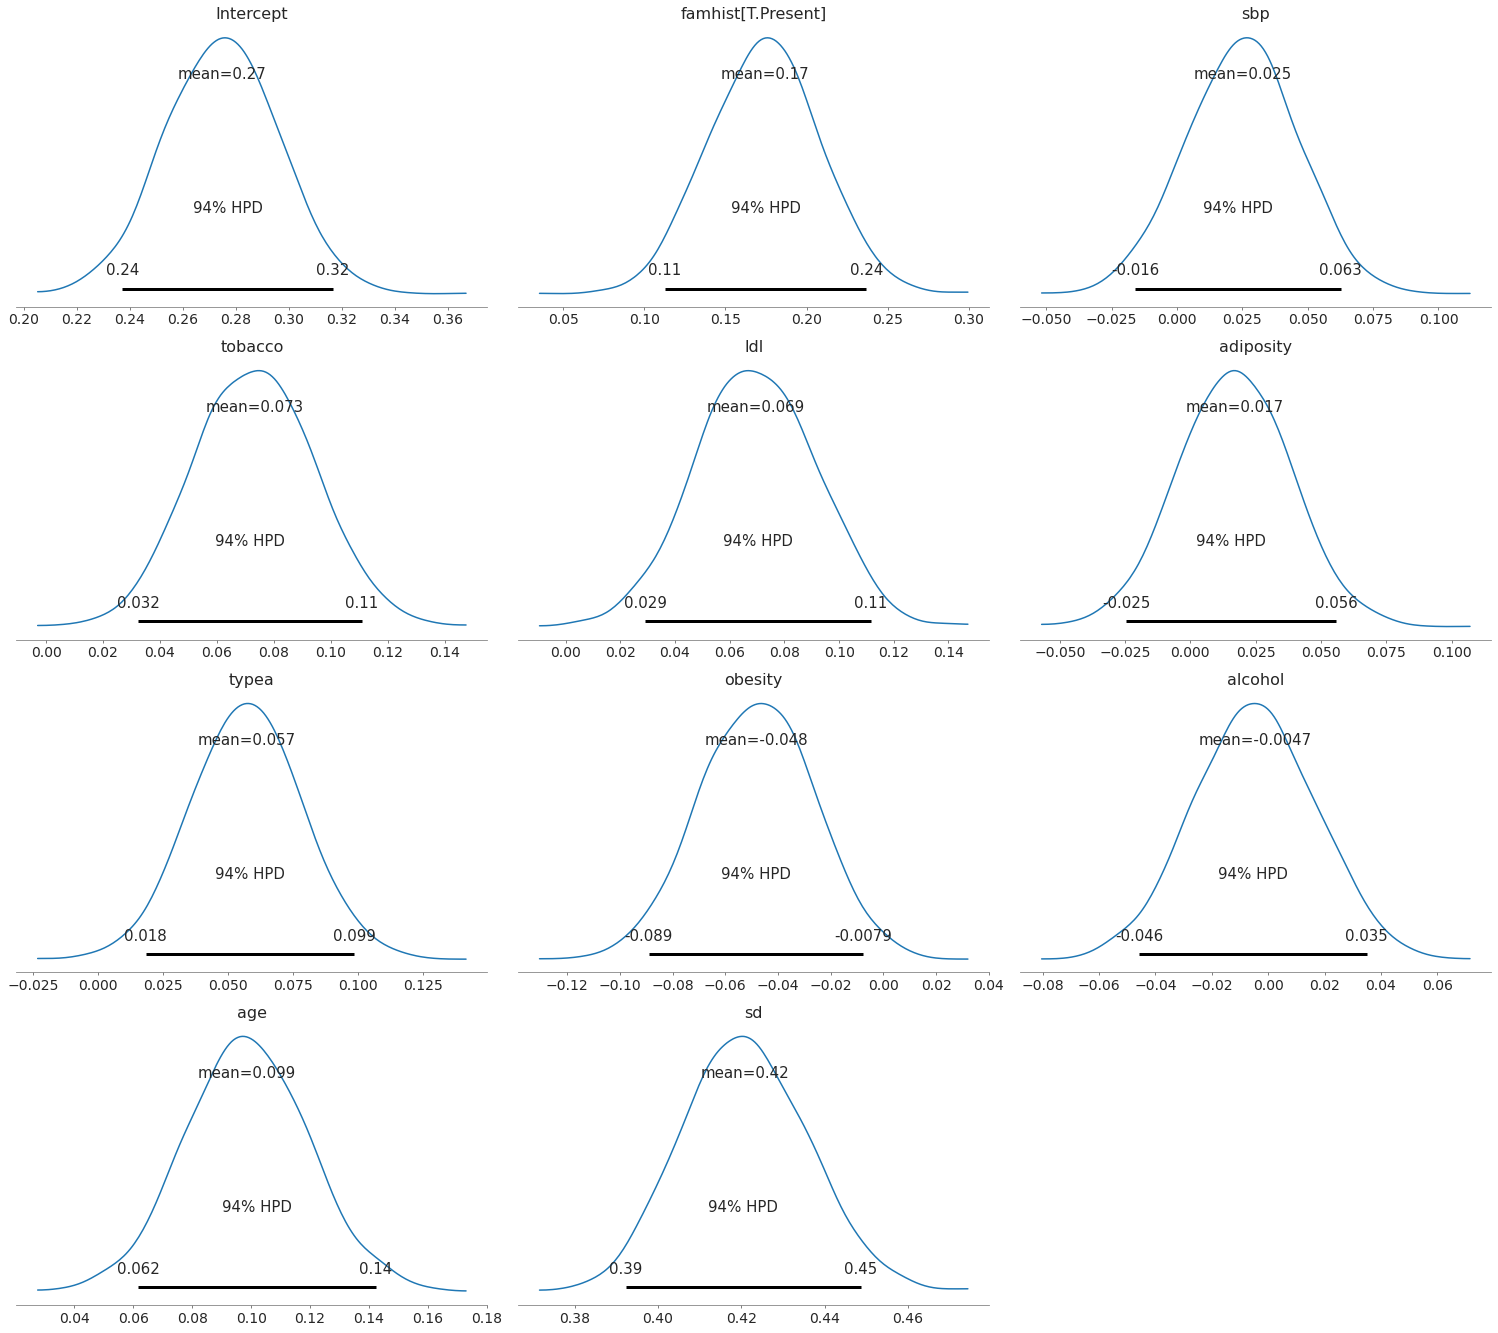

In [97]:
## Plot individual posteriors - 

import arviz as az

#az.plot_posterior(trace_approx.sample(10000));
az.plot_posterior(trace_VI);

# See: https://docs.pymc.io/en/v3/pymc-examples/examples/variational_inference/variational_api_quickstart.html

# Original Logistic Regression Model - no priors

In [98]:
with pm.Model() as model:
    pm.glm.GLM.from_formula(formula = 'chd ~ sbp + tobacco + ldl + adiposity + typea + obesity + alcohol + age + famhist', 
                            data = chd_data, 
                            family = pm.glm.families.Binomial())

    #trace = pm.sample(5000) 
    approx = pm.fit(50000, method = 'advi')

Average Loss = 318.69: 100%|██████████| 50000/50000 [00:37<00:00, 1334.83it/s]


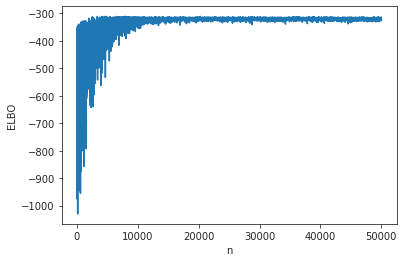

In [99]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [ ]:
trace_VI_base = approx.sample(draws=5000)

In [ ]:
plot_traces(trace_VI_base)

In [ ]:
# The creates a matplotlib plot, so we can modify with standard matplotlib commands
pm.plots.forestplot(trace_VI_base, figsize=(12, 5))
plt.grid()  # add a grid to the plot

In [ ]:
pm.summary(trace_VI_base).round(2)